成功读取 7 颗脉冲星数据。


[1/7] J1041-1942   | 3D Kick: 505.5 | Radial: 485.3 km/s


[2/7] J1115+5030   | 3D Kick: 479.3 | Radial: 432.9 km/s


[3/7] J2326+6113   | 3D Kick: 755.1 | Radial: 747.1 km/s


[4/7] J1321+8323   | 3D Kick: 1021.5 | Radial: 998.9 km/s


[5/7] J0152-1637   | 3D Kick: 474.9 | Radial: 291.6 km/s


[6/7] J1543-0620   | 3D Kick: 411.9 | Radial: 254.9 km/s


[7/7] J1840+5640   | 3D Kick: 676.8 | Radial: 661.9 km/s

分析完成。总样本数: 7000


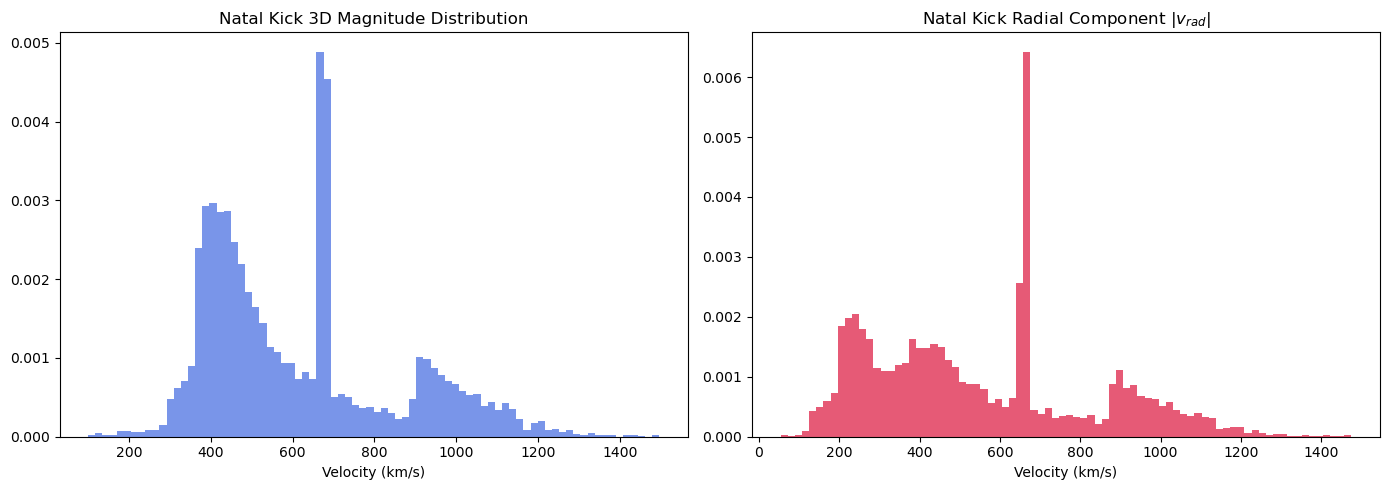

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, vcirc
from galpy.util import conversion
import astropy.units as u

# ==========================================
# 1. 物理环境配置与辅助函数
# ==========================================
RO_KPC = 8.12
VO_KMS = 220.0
POT = MWPotential2014
N_SAMPLES = 1000  # 每个源生成的样本数
V_MAX_CAP = 5000.0 # 速度上限过滤

def sample_dist(center, err_plus, err_minus, n_needed, oversample=5):
    """ 
    拒绝采样函数：生成满足正值的非对称高斯距离样本
    """
    valid_samples = np.array([])
    while len(valid_samples) < n_needed:
        n_batch = (n_needed - len(valid_samples)) * oversample
        n_batch = max(n_batch, 100)
        
        # 使用 truncnorm 确保在生成阶段就限制范围，提高效率
        # 逻辑：分两片生成，合并后过滤负值
        upper = truncnorm.rvs(0, np.inf, loc=center, scale=err_plus, size=n_batch // 2)
        lower = truncnorm.rvs(-np.inf, 0, loc=center, scale=err_minus, size=n_batch - (n_batch // 2))
        batch = np.concatenate((upper, lower))
        
        good_batch = batch[batch > 0]
        valid_samples = np.concatenate((valid_samples, good_batch))
    
    result = valid_samples[:n_needed]
    np.random.shuffle(result)
    return result

def get_birth_kinematics(orbit_obj, age_myr):
    """ 
    核心回溯函数：计算出生时刻的 3D Kick 大小和 径向分量大小 
    """
    time_unit_gyr = conversion.time_in_Gyr(ro=RO_KPC, vo=VO_KMS)
    # 回溯时间点：[现在, 出生时刻]
    ts_galpy = np.array([0, -(age_myr / 1000.0) / time_unit_gyr])
    
    # 1. 轨道回溯积分
    orbit_obj.integrate(ts_galpy, POT, method='dop853')
    
    # 2. 提取出生时刻 (ts_galpy[-1]) 的银心坐标和速度
    x = orbit_obj.x(ts_galpy[-1], use_physical=True)
    y = orbit_obj.y(ts_galpy[-1], use_physical=True)
    z = orbit_obj.z(ts_galpy[-1], use_physical=True)
    vx = orbit_obj.vx(ts_galpy[-1], use_physical=True)
    vy = orbit_obj.vy(ts_galpy[-1], use_physical=True)
    vz = orbit_obj.vz(ts_galpy[-1], use_physical=True)
    
    # 3. 计算出生位置的 LSR 速度
    R_cyl = np.sqrt(x**2 + y**2)
    vc_local = vcirc(POT, R_cyl/RO_KPC) * VO_KMS
    v_lsr_x = -vc_local * (y / R_cyl)
    v_lsr_y =  vc_local * (x / R_cyl)
    v_lsr_z = 0 
    
    # 4. 得到出生时刻的 Kick 速度矢量 (相对于出生地 LSR)
    vk_x = vx - v_lsr_x
    vk_y = vy - v_lsr_y
    vk_z = vz - v_lsr_z
    
    # 3D Kick 总大小
    v_3d_kick = np.sqrt(vk_x**2 + vk_y**2 + vk_z**2)
    
    # 5. 计算径向分量：投影到出生位置的视线方向
    # 太阳位置在 (RO_KPC, 0, 0)
    dx, dy, dz = x - RO_KPC, y, z
    dist_to_sun = np.sqrt(dx**2 + dy**2 + dz**2)
    
    # 投影：(Vk · r_vector) / |r_vector|
    v_rad_kick = (vk_x * dx + vk_y * dy + vk_z * dz) / dist_to_sun
    
    return v_3d_kick, np.abs(v_rad_kick)

# ==========================================
# 2. 数据读取与处理
# ==========================================
input_file = '/home/lz/galpy2.xlsx'
try:
    df = pd.read_excel(input_file)
    df.fillna(0, inplace=True)
    print(f"成功读取 {len(df)} 颗脉冲星数据。")
except Exception as e:
    print(f"无法读取文件: {e}")
    df = pd.DataFrame()

flat_v3d_for_bayes = []
flat_vrad_for_bayes = []

for i, row in df.iterrows():
    try:
        name = row['Name']
        ra, dec = row['RA'], row['DEC']
        dist_cen, dist_upp, dist_low = row['Dist'], row['Dist_upp'], row['Dist_low']
        
        # 自行及误差处理
        pmra_cen = row['pmra']
        pmra_err = row.get('pmra_err', row.get('pm_err', 0.1))
        pmdec_cen = row['pmdec']
        pmdec_err = row.get('pmdec_err', row.get('pmdec_error', 0.1))
        
        # 几何与年龄
        zeta = row['zeta']
        raw_age = row['age']
        psr_age_myr = raw_age / 1e6 if raw_age > 1000 else raw_age
        
        # --- MC 采样 ---
        sim_dist = sample_dist(dist_cen, dist_upp, dist_low, N_SAMPLES)
        sim_pmra = np.random.normal(pmra_cen, pmra_err, N_SAMPLES)
        sim_pmdec = np.random.normal(pmdec_cen, pmdec_err, N_SAMPLES)
        
        # --- 速度推导 (对齐假设) ---
        sim_vt = 4.74047 * sim_dist * np.sqrt(sim_pmra**2 + sim_pmdec**2)
        tan_zeta = np.tan(np.radians(zeta))
        # 保护 tan_zeta 极小值
        sim_vr = sim_vt / tan_zeta if abs(tan_zeta) > 1e-4 else np.zeros(N_SAMPLES)
        
        # --- 建立轨道 ---
        o_mc = Orbit(
            [ra * np.ones(N_SAMPLES), 
             dec * np.ones(N_SAMPLES), 
             sim_dist, 
             sim_pmra, 
             sim_pmdec, 
             sim_vr],
            radec=True, ro=RO_KPC, vo=VO_KMS
        )
        
        # --- 回溯计算 ---
        v3d_kicks, vrad_kicks = get_birth_kinematics(o_mc, psr_age_myr)
        
        # --- 数据清洗与存储 ---
        mask = np.isfinite(v3d_kicks) & (v3d_kicks < V_MAX_CAP)
        
        clean_v3d = v3d_kicks[mask]
        clean_vrad = vrad_kicks[mask]
        
        flat_v3d_for_bayes.extend(clean_v3d)
        flat_vrad_for_bayes.extend(clean_vrad)
        
        print(f"[{i+1}/{len(df)}] {name:<12} | 3D Kick: {np.mean(clean_v3d):.1f} | Radial: {np.mean(clean_vrad):.1f} km/s")

    except Exception as e:
        print(f"❌ 处理 {row.get('Name', 'Unknown')} 时出错: {e}")

# ==========================================
# 3. 结果保存与可视化
# ==========================================
final_v3d = np.array(flat_v3d_for_bayes)
final_vrad = np.array(flat_vrad_for_bayes)

if len(final_v3d) > 0:
    # 保存数据供后续贝叶斯分析使用
    np.savetxt("birth_vrad_alignment.txt", final_vrad)
    print(f"\n分析完成。总样本数: {len(final_v3d)}")
    
    # 绘图对比
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    ax[0].hist(final_v3d, bins=80, color='royalblue', alpha=0.7, density=True)
    ax[0].set_title('Natal Kick 3D Magnitude Distribution')
    ax[0].set_xlabel('Velocity (km/s)')
    
    ax[1].hist(final_vrad, bins=80, color='crimson', alpha=0.7, density=True)
    ax[1].set_title('Natal Kick Radial Component $|v_{rad}|$')
    ax[1].set_xlabel('Velocity (km/s)')
    
    plt.tight_layout()
    plt.show()

### Calculate 1D velocity

In [7]:
import pandas as pd
data=pd.read_excel('/home/lz/work/pulsar_kick_velocity/Pulsar_PA15_new_parallax.xlsx')
name = list(data.iloc[:,0]) 
parallax = list(data.iloc[:,1]) 
p_err_up = list(data.iloc[:,2]) 
p_err_low = list(data.iloc[:,3]) 
alpha = list(data.iloc[:,4]) 
alpha_err=list(data.iloc[:,5]) 
beta=list(data.iloc[:,6]) 
beta_err=list(data.iloc[:,7]) 
zeta=list(data.iloc[:,8])

In [8]:
#将视差转化为距离kpc，并将list 转化为numpy
distance = [1 / p for p in parallax]  # 对每个视差值计算距离
distance=np.array(distance)
parallax=np.array(parallax)
alpha = np.array(alpha)  # 将 alpha 转换为数组
beta = np.array(beta) 
zeta=np.array(zeta)
#Pulsar_PA15_new数组的2D速度
V_trans= 4.74*distance*np.sqrt(alpha**2+beta**2) #km/s
#zeta是自转-视线夹角
tan_zeta = np.tan(np.deg2rad(180-zeta))
sqrt_alpha_beta=np.sqrt(alpha**2+beta**2)
V_1D=V_trans/np.abs(tan_zeta)
print(V_trans)
print(V_1D)
print(zeta)
print(name)

[324.28109939 104.15048577  78.52653084 177.01584337 281.82451634]
[98.52413104 57.0207254  38.98090844 71.51904311 72.36023708]
[ 73.1  61.3  63.6  68.  104.4]
['J0139+5814', 'J0534+2200', 'J0835-4510', 'J1932+1059', 'J2157+4017']


In [9]:
dV_dp = - (4.74 * sqrt_alpha_beta) / (parallax**2 * np.abs(tan_zeta)) #V 对parallax的偏导数
dV_dalpha = (4.74 * alpha) / (parallax * sqrt_alpha_beta * np.abs(tan_zeta)) # V对 \alpha的偏导数
dV_dbeta = (4.74 * beta) / (parallax * sqrt_alpha_beta * np.abs(tan_zeta))  # V对 \beta的偏导数

# 计算上限误差
sigma_V_pos = np.sqrt(
    (dV_dp * p_err_low)**2 +
    (dV_dalpha * alpha_err)**2 +
    (dV_dbeta * beta_err)**2
)

# 计算下限误差
sigma_V_neg = np.sqrt(
    (dV_dp * p_err_up)**2 +
    (dV_dalpha * alpha_err)**2 +
    (dV_dbeta * beta_err)**2
)

print("V =", V_1D, "km/s")
print("sigma_V_pos=",sigma_V_pos, "km/s")
print("sigma_V_neg=",sigma_V_neg, "km/s")

V = [98.52413104 57.0207254  38.98090844 71.51904311 72.36023708] km/s
sigma_V_pos= [10.6547415   6.46339492  2.22801828  1.80924779 15.51201999] km/s
sigma_V_neg= [10.6547415   6.46339492  2.22801828  1.80924779 15.51201999] km/s


### Read another data

In [12]:
data1=pd.read_excel('/home/lz/work/pulsar_kick_velocity/Pulsar_PA15_new.xlsx')
name1 = list(data1.iloc[:,0]) 
distance1=list(data1.iloc[:,1])
alpha1=list(data1.iloc[:,2])
alpha1_err=list(data1.iloc[:,3])
beta1=list(data1.iloc[:,4])
beta1_err=list(data1.iloc[:,5])
zeta1=list(data1.iloc[:,6])
zeta1_err=list(data1.iloc[:,7])

In [13]:
distance1=np.array(distance1)
distance1_err=0.2*distance1
alpha1=np.array(alpha1)
beta1=np.array(beta1)
zeta1=np.array(zeta1)
sqrt_alpha_beta1=np.sqrt(alpha1**2+beta1**2)
V_trans1= 4.74* distance1 * np.sqrt(alpha1**2+beta1**2) #km/s
tan_zeta1 = np.tan(np.deg2rad(180-zeta1))
tan_zeta1=np.abs(tan_zeta1)
V1_1D=V_trans1/tan_zeta1
print(V1_1D)

[ 31.14572623 570.81134805 233.57900559 186.4243605  112.51305896]


In [14]:
cos_zeta1=np.cos(np.deg2rad(180-zeta1))
dV_dD1 = (4.74 * sqrt_alpha_beta1) / tan_zeta1
dV_dalpha1 = (4.74 * distance1 * alpha1) / (sqrt_alpha_beta1 * tan_zeta1)
dV_dbeta1 = (4.74 * distance1 * beta1) / (sqrt_alpha_beta1 * tan_zeta1)
dV_dzeta1 = -V_trans1/(cos_zeta1**2*tan_zeta1**2)  # 注意负号

sigma_V_distance=dV_dD1 * distance1
sigma_V_alpha = dV_dalpha1 * alpha1_err
sigma_V_beta = dV_dbeta1 * beta1_err
sigma_V_zeta = dV_dzeta1 * zeta1_err

# 计算总误差
sigma_V = np.sqrt(
    sigma_V_distance**2 +
    sigma_V_alpha**2 +
    sigma_V_beta**2 +
    sigma_V_zeta**2
)

print("V =", V1_1D, "km/s ±", sigma_V, "km/s")

V = [ 31.14572623 570.81134805 233.57900559 186.4243605  112.51305896] km/s ± [ 31.94454891 571.34039549 396.53644156 192.16729013 123.49431018] km/s


In [15]:
v_radial=np.concatenate((V_1D,V1_1D))
v_radial_pos=np.concatenate((sigma_V_pos,sigma_V))
v_radial_neg=np.concatenate((sigma_V_neg,sigma_V))

In [17]:
V_radial=np.concatenate((v_radial,[81]))
V_radial_pos=np.concatenate((v_radial_pos,[158]))
V_radial_neg=np.concatenate((v_radial_neg,[150]))


开始处理 11 个源的速度采样...
源 1: Center=98.5 (+10.7/-10.7) -> Sampled Mean=98.4
源 2: Center=57.0 (+6.5/-6.5) -> Sampled Mean=57.0
源 3: Center=39.0 (+2.2/-2.2) -> Sampled Mean=39.0
源 4: Center=71.5 (+1.8/-1.8) -> Sampled Mean=71.4
源 5: Center=72.4 (+15.5/-15.5) -> Sampled Mean=72.7
源 6: Center=31.1 (+31.9/-31.9) -> Sampled Mean=41.4
源 7: Center=570.8 (+571.3/-571.3) -> Sampled Mean=729.9
源 8: Center=233.6 (+396.5/-396.5) -> Sampled Mean=405.5
源 9: Center=186.4 (+192.2/-192.2) -> Sampled Mean=248.5
源 10: Center=112.5 (+123.5/-123.5) -> Sampled Mean=156.3
源 11: Center=81.0 (+158.0/-150.0) -> Sampled Mean=160.9

处理完成！
最终数组形状: (11000,)
是否包含负值: False
11000


(array([5.220e+02, 1.684e+03, 2.291e+03, 1.731e+03, 9.960e+02, 3.170e+02,
        2.940e+02, 2.630e+02, 2.490e+02, 2.100e+02, 2.460e+02, 1.750e+02,
        1.720e+02, 1.420e+02, 1.290e+02, 1.140e+02, 9.300e+01, 8.500e+01,
        7.800e+01, 7.300e+01, 7.700e+01, 6.600e+01, 6.000e+01, 6.500e+01,
        4.700e+01, 4.200e+01, 4.300e+01, 4.000e+01, 3.800e+01, 2.900e+01,
        3.000e+01, 3.400e+01, 2.800e+01, 3.500e+01, 2.600e+01, 3.400e+01,
        3.300e+01, 2.600e+01, 1.600e+01, 1.900e+01, 2.700e+01, 2.800e+01,
        2.100e+01, 1.700e+01, 1.300e+01, 1.600e+01, 7.000e+00, 1.500e+01,
        1.200e+01, 9.000e+00, 1.000e+01, 9.000e+00, 1.600e+01, 1.000e+01,
        8.000e+00, 4.000e+00, 1.800e+01, 9.000e+00, 6.000e+00, 6.000e+00,
        6.000e+00, 4.000e+00, 8.000e+00, 8.000e+00, 5.000e+00, 4.000e+00,
        4.000e+00, 5.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 4.000e+00, 3.000e+00, 3.000e+00, 5.000e+00,
        2.000e+00, 3.000e+00, 1.000e+0

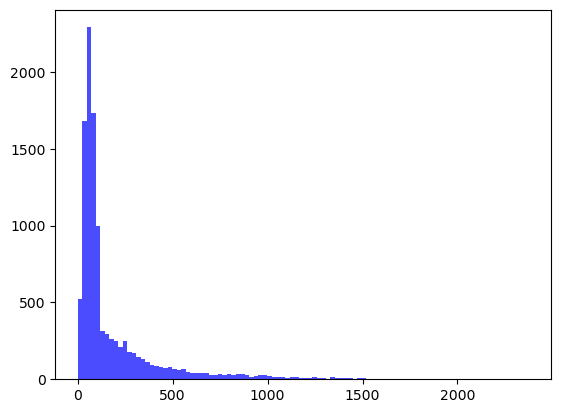

In [20]:
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
# ==========================================
# 1. 定义拒绝采样函数 (和之前处理 Dist 的逻辑一模一样)
# ==========================================
def sample_source(center, err_plus, err_minus, n_needed=1000, batch_size=5000):
    valid_samples = np.array([])
    # 循环直到凑够 n_needed (1000) 个
    while len(valid_samples) < n_needed:
        # 1. 每次生成一大批 (5000个)
        # 上半部分 (50%)
        upper = truncnorm.rvs(0, np.inf, loc=center, scale=err_plus, size=batch_size // 2)
        # 下半部分 (50%)
        lower = truncnorm.rvs(-np.inf, 0, loc=center, scale=err_minus, size=batch_size - (batch_size // 2))
        # 拼接
        batch = np.concatenate((upper, lower))
        # 2. 【核心】拒绝负值 (只保留 > 0)
        # 速度必须是正的，物理上没有负速率
        good_batch = batch[batch > 0]
        # 3. 加入池子
        valid_samples = np.concatenate((valid_samples, good_batch))
    
    # 4. 打乱并截取前 1000 个
    np.random.shuffle(valid_samples)
    return valid_samples[:n_needed]

print(f"开始处理 {len(V_radial)} 个源的速度采样...")

all_radial_samples = []
# 遍历每个源
for i in range(len(V_radial)):
    # 提取当前源的参数
    v_cen = V_radial[i]
    v_upp = V_radial_pos[i]
    v_low = V_radial_neg[i]
    # 执行采样
    # 这里会自动处理负值拒绝，并保证返回严格的 1000 个
    samples = sample_source(v_cen, v_upp, v_low, n_needed=1000)
    # 存入列表
    all_radial_samples.extend(samples)
    
    # 打印进度 (可选)
    print(f"源 {i+1}: Center={v_cen:.1f} (+{v_upp:.1f}/-{v_low:.1f}) -> Sampled Mean={np.mean(samples):.1f}")
final_v_radial_flat = np.array(all_radial_samples)
print("\n处理完成！")
print(f"最终数组形状: {final_v_radial_flat.shape}") # 应该是 (12000,)
print(f"是否包含负值: {np.any(final_v_radial_flat < 0)}") # 应该是 False

# 如果需要保存
np.savetxt("v_radial_mc_samples.txt", final_v_radial_flat)
print(len(final_v_radial_flat))
plt.hist(final_v_radial_flat, bins=100, alpha=0.7, color='blue')

18000


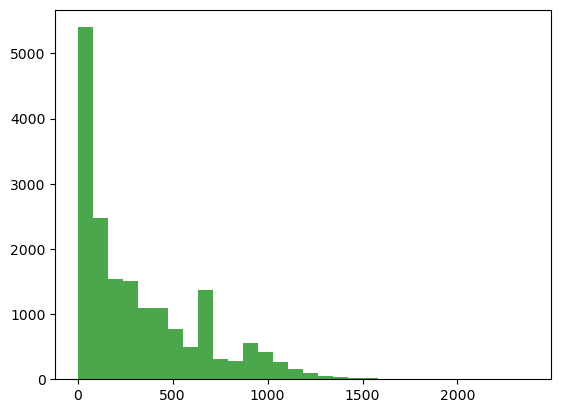

In [26]:
samples_radial_18=np.concatenate([final_vrad,final_v_radial_flat])
plt.hist(samples_radial_18, bins=30, alpha=0.7, color='green')
print(len(samples_radial_18))
np.savetxt("v_radial_mc_samples_18.txt", samples_radial_18)

In [3]:
samples_radial_18=np.loadtxt("v_radial_mc_samples_18.txt")

In [4]:
import numpy as np
from scipy.special import erf
from scipy.stats import beta as beta_dist
from scipy.stats import truncnorm
from scipy.interpolate import interp1d
import bilby
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from bilby.core.prior import Uniform
from bilby.core.sampler import run_sampler
from bilby.core.prior import LogUniform
from bilby.hyper.likelihood import HyperparameterLikelihood
from scipy import interpolate
from scipy import integrate
import random
import argparse
import os
import glob
import warnings
warnings.filterwarnings("ignore")
#####################
samples_new=samples_radial_18
outdir='hy_outdir'
data_exp=samples_new
import sys
#import utilizes
n_samples=1000
npool=300
NN=int(len(data_exp)/n_samples)
nlive=2000
mx=n_samples
#################################
data_df=list()
ns_m=abs(data_exp)
for i in range(NN):
    re=pd.DataFrame(ns_m[i*mx:(i+1)*mx],columns=['mu'])
    data_df.append(re)
samples = data_df

def run_prior(dataset):
    return 1



22:36 bilby INFO    : Running for label 'u_hype_58916', output will be saved to 'hy_outdir'
22:36 bilby INFO    : Analysis priors:
22:36 bilby INFO    : k=LogUniform(minimum=0.01, maximum=3, name='k', latex_label='$k$', unit=None, boundary=None)
22:36 bilby INFO    : theta=Uniform(minimum=1, maximum=800, name='theta', latex_label='$\\theta$(km/s)', unit=None, boundary=None)
22:36 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
22:36 bilby INFO    : Analysis likelihood noise evidence: 0
22:36 bilby INFO    : Single likelihood evaluation took 1.847e-04 s
22:36 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'rstate': None, 'queue_size': 300, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'boo

1it [00:00, ?it/s]

/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /

/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /

/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /

/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /

/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountere

22:36 bilby INFO    : Written checkpoint file hy_outdir/u_hype_58916_resume.pickle
22:36 bilby INFO    : Starting to close worker pool.
22:36 bilby INFO    : Finished closing worker pool.
22:36 bilby INFO    : Rejection sampling nested samples to obtain 5728 posterior samples
22:36 bilby INFO    : Sampling time: 0:00:19.217799
22:36 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 


22:37 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
22:37 bilby INFO    : Summary of results:
nsamples: 5728
ln_noise_evidence:  0.000
ln_evidence: -123.715 +/-  0.046
ln_bayes_factor: -123.715 +/-  0.046



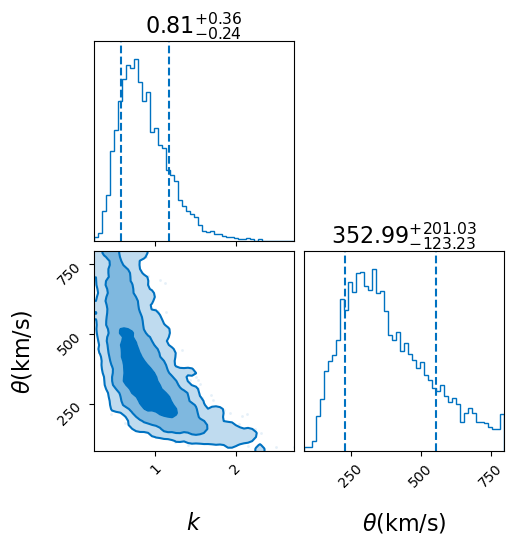

In [44]:
from scipy.special import beta
from scipy.special import gamma
def hyper_prior_gamma(dataset, k,theta):
    return (1 / (gamma(k)*theta**k)) * dataset['mu']**(k-1) *np.exp(-dataset['mu']/theta)

hp_priors_gamma = dict(k=LogUniform(0.01,3, 'k',r'$k$'),
                theta=Uniform(1, 800, 'theta',r'$\theta$(km/s)') )

hyper_prior_gamma=hyper_prior_gamma

hp_likelihood_gamma = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_gamma,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_gamma =hp_priors_gamma
# And run sampler
result_gamma = run_sampler(
    likelihood=hp_likelihood_gamma, priors=hp_priors_gamma, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_gamma.plot_corner(title_fmt='.1f')

22:29 bilby INFO    : Running for label 'u_hype_62060', output will be saved to 'hy_outdir'


<>:4: SyntaxWarning: invalid escape sequence '\m'

<>:5: SyntaxWarning: invalid escape sequence '\s'

<>:4: SyntaxWarning: invalid escape sequence '\m'

<>:5: SyntaxWarning: invalid escape sequence '\s'

/tmp/ipykernel_1567118/2066600038.py:4: SyntaxWarning: invalid escape sequence '\m'
  hp_priors_lognorm = dict(s_mu=Uniform(3.5, 6, 's_mu', '$\mu$'),

/tmp/ipykernel_1567118/2066600038.py:5: SyntaxWarning: invalid escape sequence '\s'
  s_sigma=LogUniform(0.1, 2.5, 's_sigma', '$\sigma$') )



22:29 bilby INFO    : Analysis priors:
22:29 bilby INFO    : s_mu=Uniform(minimum=3.5, maximum=6, name='s_mu', latex_label='$\\mu$', unit=None, boundary=None)
22:29 bilby INFO    : s_sigma=LogUniform(minimum=0.1, maximum=2.5, name='s_sigma', latex_label='$\\sigma$', unit=None, boundary=None)
22:29 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
22:29 bilby INFO    : Analysis likelihood noise evidence: 0
22:29 bilby INFO    : Single likelihood evaluation took 1.570e-04 s
22:29 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'rstate': None, 'queue_size': 300, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'walks': 100, 'facc': 0.2, 'slices': None, 'ncdim': None, 'blob': Fal

1it [00:00, ?it/s]

22:30 bilby INFO    : Written checkpoint file hy_outdir/u_hype_62060_resume.pickle
22:30 bilby INFO    : Starting to close worker pool.
22:30 bilby INFO    : Finished closing worker pool.
22:30 bilby INFO    : Rejection sampling nested samples to obtain 5495 posterior samples
22:30 bilby INFO    : Sampling time: 0:00:17.032616
22:30 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 


22:30 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
22:30 bilby INFO    : Summary of results:
nsamples: 5495
ln_noise_evidence:  0.000
ln_evidence: -123.080 +/-  0.044
ln_bayes_factor: -123.080 +/-  0.044



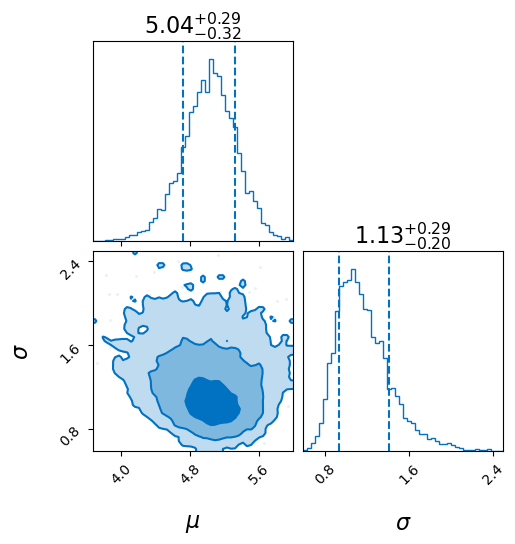

In [37]:
def hyper_prior_lognorm(dataset, s_mu, s_sigma):
    return np.exp(- (np.log(dataset['mu']) - s_mu)**2 / (2 * s_sigma**2)) /\
        (2 * np.pi * s_sigma**2)**0.5/(dataset['mu'])
hp_priors_lognorm = dict(s_mu=Uniform(3.5, 6, 's_mu', '$\mu$'),
                 s_sigma=LogUniform(0.1, 2.5, 's_sigma', '$\sigma$') )

hyper_prior_lognorm=hyper_prior_lognorm
hp_likelihood_lognorm = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_lognorm,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_lognorm =hp_priors_lognorm

# And run sampler
result_lognorm = run_sampler(
    likelihood=hp_likelihood_lognorm, priors=hp_priors_lognorm, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_lognorm.plot_corner()

22:33 bilby INFO    : Running for label 'maxwell_hype_67786', output will be saved to 'hy_outdir'
22:33 bilby INFO    : Analysis priors:
22:33 bilby INFO    : sigma=Uniform(minimum=10, maximum=300, name='sigma', latex_label='$\\sigma$', unit=None, boundary=None)
22:33 bilby INFO    : mlo=LogUniform(minimum=0.01, maximum=100, name='mlo', latex_label='$\\rm{v^{lo}}$', unit=None, boundary=None)
22:33 bilby INFO    : mup=Uniform(minimum=400, maximum=3000, name='mup', latex_label='$\\rm{v^{up}}$', unit=None, boundary=None)
22:33 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
22:33 bilby INFO    : Analysis likelihood noise evidence: 0
22:33 bilby INFO    : Single likelihood evaluation took 3.991e-04 s
22:33 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'rstate': None, 'queue_size': 300, 'pool': Non

/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /



22:34 bilby INFO    : Generating initial points from the prior
22:34 bilby INFO    : Using the bilby-implemented ensemble rwalk sampling tracking the autocorrelation function and thinning by 2 with maximum length 500000.


1it [00:00, ?it/s]

22:34 bilby INFO    : Written checkpoint file hy_outdir/maxwell_hype_67786_resume.pickle
22:34 bilby INFO    : Starting to close worker pool.
22:34 bilby INFO    : Finished closing worker pool.


22:34 bilby INFO    : Rejection sampling nested samples to obtain 4186 posterior samples
22:34 bilby INFO    : Sampling time: 0:00:16.333426
22:34 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
22:34 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
22:34 bilby INFO    : Summary of results:
nsamples: 4186
ln_noise_evidence:  0.000
ln_evidence: -136.887 +/-  0.031
ln_bayes_factor: -136.887 +/-  0.031



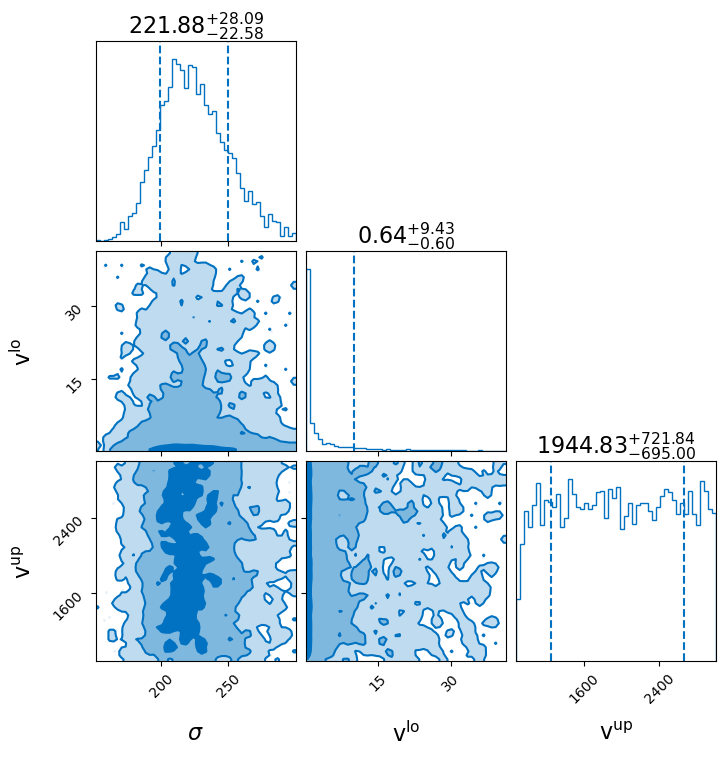

In [41]:
from scipy.stats import maxwell
from scipy.integrate import quad
def hyper_prior_maxwell(dataset,mlo,mup,sigma):
    log_likelihood = ((dataset['mu'] >= mlo) & (dataset['mu'] <= mup)) * maxwell.pdf(dataset['mu'],scale=sigma)
    return log_likelihood

hp_priors_maxwell = dict(sigma=Uniform(10, 300, 'sigma', r'$\sigma$'),
                        mlo=LogUniform(0.01,100,'mlo', r'$\rm{v^{lo}}$'),
                        mup=Uniform(400,3000,'mup', r'$\rm{v^{up}}$')
                        )

hyper_prior_maxwell = hyper_prior_maxwell
hp_likelihood_maxwell = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_maxwell,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_maxwell = hp_priors_maxwell
result_maxwell = run_sampler(
    likelihood=hp_likelihood_maxwell, priors=hp_priors_maxwell, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='maxwell_hype_{}'.format(np.random.randint(1, 88888)),
    verbose=True, clean=True, npool=npool)

result_maxwell.plot_corner()

22:32 bilby INFO    : Running for label 'double_maxwell_hype_18348', output will be saved to 'hy_outdir'
22:32 bilby INFO    : Analysis priors:
22:32 bilby INFO    : sigma1=Uniform(minimum=10, maximum=100, name='sigma1', latex_label='$\\sigma_1$(km/s)', unit=None, boundary=None)
22:32 bilby INFO    : sigma2=Uniform(minimum=10, maximum=700, name='sigma2', latex_label='$\\sigma_2$(km/s)', unit=None, boundary=None)
22:32 bilby INFO    : alpha=Uniform(minimum=0.01, maximum=0.99, name='alpha', latex_label='$\\alpha$', unit=None, boundary=None)
22:32 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
22:32 bilby INFO    : Analysis likelihood noise evidence: 0
22:32 bilby INFO    : Single likelihood evaluation took 6.815e-04 s
22:32 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'rstate': None, 'queue_si

/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /



22:33 bilby INFO    : Generating initial points from the prior
22:33 bilby INFO    : Using the bilby-implemented ensemble rwalk sampling tracking the autocorrelation function and thinning by 2 with maximum length 500000.


1it [00:00, ?it/s]

22:33 bilby INFO    : Written checkpoint file hy_outdir/double_maxwell_hype_18348_resume.pickle
22:33 bilby INFO    : Starting to close worker pool.
22:33 bilby INFO    : Finished closing worker pool.
22:33 bilby INFO    : Rejection sampling nested samples to obtain 6928 posterior samples
22:33 bilby INFO    : Sampling time: 0:00:37.038734
22:33 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 


22:33 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
22:33 bilby INFO    : Summary of results:
nsamples: 6928
ln_noise_evidence:  0.000
ln_evidence: -121.566 +/-  0.048
ln_bayes_factor: -121.566 +/-  0.048



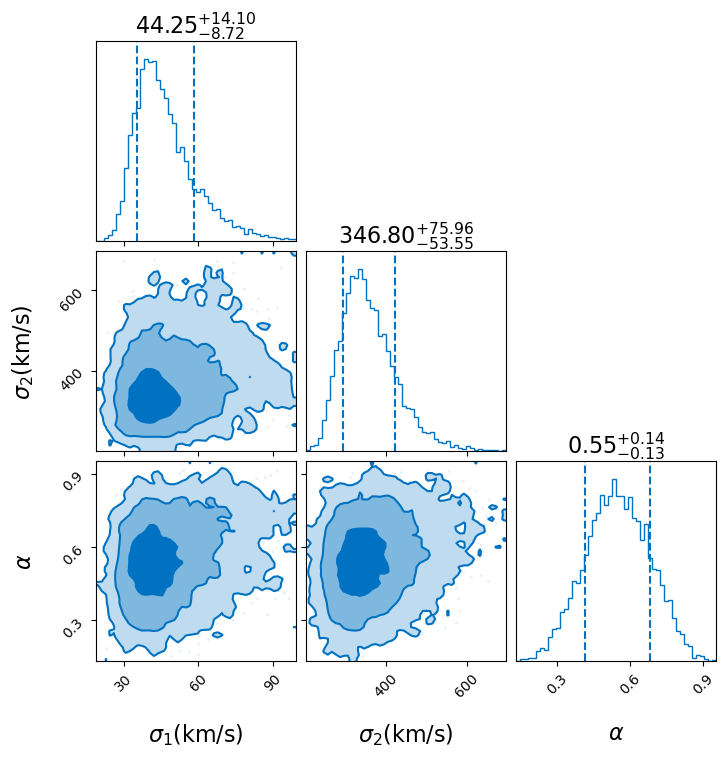

In [40]:
def hyper_prior_double_maxwell(dataset,sigma1, sigma2, alpha):
    mup=3000
    mlo=0.01
    # 数据范围限制
    sigma_constraint = (mlo < sigma1) & (sigma1 < sigma2) & (sigma2 < mup)
    valid_range = (dataset['mu'] >= mlo) & (dataset['mu'] <= mup)
    
    # Maxwell PDF for the two components
    pdf1 = maxwell.pdf(dataset['mu'], scale=sigma1)
    pdf2 = maxwell.pdf(dataset['mu'], scale=sigma2)
    # Combined mixture PDF
    mixture_pdf = alpha * pdf1 + (1 - alpha) * pdf2
    # Apply range restriction
    log_likelihood = sigma_constraint*valid_range * mixture_pdf
    return log_likelihood

hp_priors_double_maxwell = dict(
    sigma1=Uniform(10, 100, 'sigma1', r'$\sigma_1$(km/s)'),
    sigma2=Uniform(10, 700, 'sigma2', r'$\sigma_2$(km/s)'),
    alpha=Uniform(0.01, 0.99, 'alpha', r'$\alpha$')
)

hyper_prior_double_maxwell = hyper_prior_double_maxwell

hp_likelihood_double_maxwell = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_double_maxwell,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_double_maxwell = hp_priors_double_maxwell
# 运行采样器
result_2M = run_sampler(
    likelihood=hp_likelihood_double_maxwell, priors=hp_priors_double_maxwell, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='double_maxwell_hype_{}'.format(np.random.randint(1, 88888)),
    verbose=True, clean=True, npool=npool)

# 绘制角图
result_2M.plot_corner()

22:37 bilby INFO    : Running for label 'u_hype_62178', output will be saved to 'hy_outdir'


22:37 bilby INFO    : Analysis priors:
22:37 bilby INFO    : mlo=LogUniform(minimum=0.01, maximum=100, name='mlo', latex_label='$\\rm{v^l}$', unit=None, boundary=None)
22:37 bilby INFO    : mup=Uniform(minimum=100, maximum=3000, name='mup', latex_label='$\\rm{v^u}$', unit=None, boundary=None)
22:37 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
22:37 bilby INFO    : Analysis likelihood noise evidence: 0
22:37 bilby INFO    : Single likelihood evaluation took 1.124e-04 s
22:37 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'rstate': None, 'queue_size': 300, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'walks': 100, 'facc': 0.2, 'slices': None, 'ncdim': None, 'blob': Fa

/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /



22:37 bilby INFO    : Generating initial points from the prior
22:37 bilby INFO    : Using the bilby-implemented ensemble rwalk sampling tracking the autocorrelation function and thinning by 2 with maximum length 500000.


1it [00:00, ?it/s]

22:37 bilby INFO    : Written checkpoint file hy_outdir/u_hype_62178_resume.pickle
22:37 bilby INFO    : Starting to close worker pool.
22:37 bilby INFO    : Finished closing worker pool.


22:37 bilby INFO    : Rejection sampling nested samples to obtain 7331 posterior samples
22:37 bilby INFO    : Sampling time: 0:00:23.558027
22:37 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
22:37 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
22:37 bilby INFO    : Summary of results:
nsamples: 7331
ln_noise_evidence:  0.000
ln_evidence: -121.535 +/-  0.050
ln_bayes_factor: -121.535 +/-  0.050



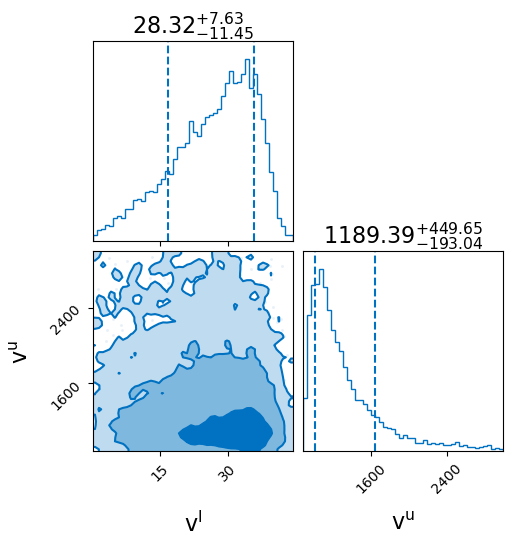

In [45]:
def hyper_prior_logu(dataset,mlo,mup):
    return (( dataset['mu'] >= mlo) & (dataset['mu'] <= mup))/( dataset['mu'] * np.log(mup / mlo) )

hp_priors_logu = dict(mlo=LogUniform(0.01, 100, 'mlo',r'$\rm{v^l}$'),
                mup=Uniform(100, 3000, 'mup',r'$\rm{v^u}$'))
#end log-uniform
hyper_prior_logu=hyper_prior_logu

hp_likelihood_logu = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_logu,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_logu =hp_priors_logu

# And run sampler
result_logu = run_sampler(
    likelihood=hp_likelihood_logu, priors=hp_priors_logu, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_logu.plot_corner()

22:41 bilby INFO    : Running for label 'u_hype_75076', output will be saved to 'hy_outdir'


<>:8: SyntaxWarning: invalid escape sequence '\m'

<>:9: SyntaxWarning: invalid escape sequence '\s'

<>:8: SyntaxWarning: invalid escape sequence '\m'

<>:9: SyntaxWarning: invalid escape sequence '\s'

/tmp/ipykernel_1567118/1040996024.py:8: SyntaxWarning: invalid escape sequence '\m'
  hp_priors_G_fixed_max_min= dict(mu=Uniform(10, 300, 's_mu', '$\mu$'),

/tmp/ipykernel_1567118/1040996024.py:9: SyntaxWarning: invalid escape sequence '\s'
  sigma=Uniform(1, 600, 's_sigma', '$\sigma$'))



22:41 bilby INFO    : Analysis priors:
22:41 bilby INFO    : mu=Uniform(minimum=10, maximum=300, name='s_mu', latex_label='$\\mu$', unit=None, boundary=None)
22:41 bilby INFO    : sigma=Uniform(minimum=1, maximum=600, name='s_sigma', latex_label='$\\sigma$', unit=None, boundary=None)
22:41 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
22:41 bilby INFO    : Analysis likelihood noise evidence: 0
22:41 bilby INFO    : Single likelihood evaluation took 2.352e-04 s
22:41 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'rstate': None, 'queue_size': 300, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'walks': 100, 'facc': 0.2, 'slices': None, 'ncdim': None, 'blob': False, 'sav

/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /



22:41 bilby INFO    : Generating initial points from the prior
22:41 bilby INFO    : Using the bilby-implemented ensemble rwalk sampling tracking the autocorrelation function and thinning by 2 with maximum length 500000.


1it [00:00, ?it/s]

22:42 bilby INFO    : Written checkpoint file hy_outdir/u_hype_75076_resume.pickle
22:42 bilby INFO    : Starting to close worker pool.
22:42 bilby INFO    : Finished closing worker pool.
22:42 bilby INFO    : Rejection sampling nested samples to obtain 5267 posterior samples
22:42 bilby INFO    : Sampling time: 0:00:13.035464
22:42 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 


22:42 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
22:42 bilby INFO    : Summary of results:
nsamples: 5267
ln_noise_evidence:  0.000
ln_evidence: -123.393 +/-  0.031
ln_bayes_factor: -123.393 +/-  0.031



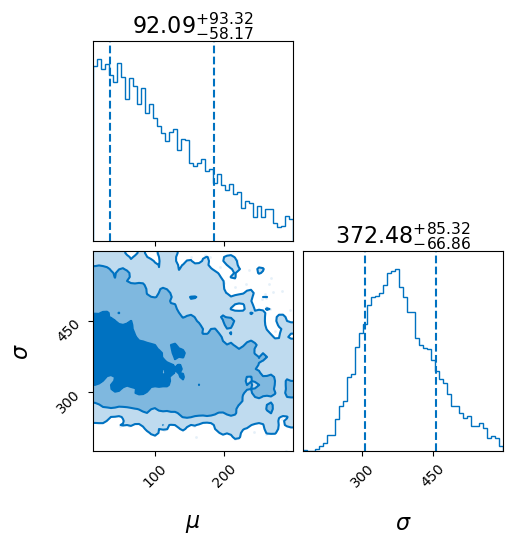

In [48]:
#begin Gaussian model with fixed upper and lower mass
def hyper_prior_G_fixed_max_min(dataset, mu, sigma):
    mup=3000
    mlo=0.01
    normalisingTerm = 0.5 * ( erf((mu-mlo)/(np.sqrt(2) * sigma)) -  erf((mu-mup)/(np.sqrt(2) * sigma)) )
    return ( ( dataset['mu'] >= mlo) & (dataset['mu'] <= mup))*((mu>mlo)&(mu<mup)) * (np.exp(- (dataset['mu'] - mu)**2 / (2 * sigma**2)) /\
        (2 * np.pi * sigma**2)**0.5) / normalisingTerm 
hp_priors_G_fixed_max_min= dict(mu=Uniform(10, 300, 's_mu', '$\mu$'),
                 sigma=Uniform(1, 600, 's_sigma', '$\sigma$'))
#end Gaussian with fixed upper and lower ma
#end Gaussian model 
hyper_prior_G=hyper_prior_G_fixed_max_min

hp_likelihood_G = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_G,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_G =hp_priors_G_fixed_max_min

# And run sampler
result_G = run_sampler(
    likelihood=hp_likelihood_G, priors=hp_priors_G, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_G.plot_corner()

22:45 bilby INFO    : Running for label 'u_hype_46400', output will be saved to 'hy_outdir'


<>:9: SyntaxWarning: invalid escape sequence '\m'

<>:10: SyntaxWarning: invalid escape sequence '\s'

<>:11: SyntaxWarning: invalid escape sequence '\m'

<>:12: SyntaxWarning: invalid escape sequence '\s'

<>:9: SyntaxWarning: invalid escape sequence '\m'

<>:10: SyntaxWarning: invalid escape sequence '\s'

<>:11: SyntaxWarning: invalid escape sequence '\m'

<>:12: SyntaxWarning: invalid escape sequence '\s'

/tmp/ipykernel_1567118/58818743.py:9: SyntaxWarning: invalid escape sequence '\m'
  hp_priors_2G_fixed_max_min = dict(mu1=Uniform(1, 150, 'mu1', '$\mu_1$'),

/tmp/ipykernel_1567118/58818743.py:10: SyntaxWarning: invalid escape sequence '\s'
  sigma1=Uniform(10, 400, 'sigma1', '$\sigma_1$'),

/tmp/ipykernel_1567118/58818743.py:11: SyntaxWarning: invalid escape sequence '\m'
  mu2=Uniform(1,600, 'mu2', '$\mu_2$'),

/tmp/ipykernel_1567118/58818743.py:12: SyntaxWarning: invalid escape sequence '\s'
  sigma2=LogUniform(1, 4000, 'sigma2', '$\sigma_2$'),



22:45 bilby INFO    : Analysis priors:
22:45 bilby INFO    : mu1=Uniform(minimum=1, maximum=150, name='mu1', latex_label='$\\mu_1$', unit=None, boundary=None)
22:45 bilby INFO    : sigma1=Uniform(minimum=10, maximum=400, name='sigma1', latex_label='$\\sigma_1$', unit=None, boundary=None)
22:45 bilby INFO    : mu2=Uniform(minimum=1, maximum=600, name='mu2', latex_label='$\\mu_2$', unit=None, boundary=None)
22:45 bilby INFO    : sigma2=LogUniform(minimum=1, maximum=4000, name='sigma2', latex_label='$\\sigma_2$', unit=None, boundary=None)
22:45 bilby INFO    : alpha=Uniform(minimum=0.01, maximum=0.99, name='alpha', latex_label='$\\alpha$', unit=None, boundary=None)
22:45 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
22:45 bilby INFO    : Analysis likelihood noise evidence: 0
22:45 bilby INFO    : Single likelihood evaluation took 4.505e-04 s
22:45 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'samp

/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /



22:45 bilby INFO    : Generating initial points from the prior
22:45 bilby INFO    : Using the bilby-implemented ensemble rwalk sampling tracking the autocorrelation function and thinning by 2 with maximum length 500000.


1it [00:00, ?it/s]

22:50 bilby INFO    : Written checkpoint file hy_outdir/u_hype_46400_resume.pickle
22:50 bilby INFO    : Starting to close worker pool.
22:50 bilby INFO    : Finished closing worker pool.


22:50 bilby INFO    : Rejection sampling nested samples to obtain 8559 posterior samples
22:50 bilby INFO    : Sampling time: 0:04:57.570539
22:50 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
22:50 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
22:50 bilby INFO    : Summary of results:
nsamples: 8559
ln_noise_evidence:  0.000
ln_evidence: -123.216 +/-  0.052
ln_bayes_factor: -123.216 +/-  0.052



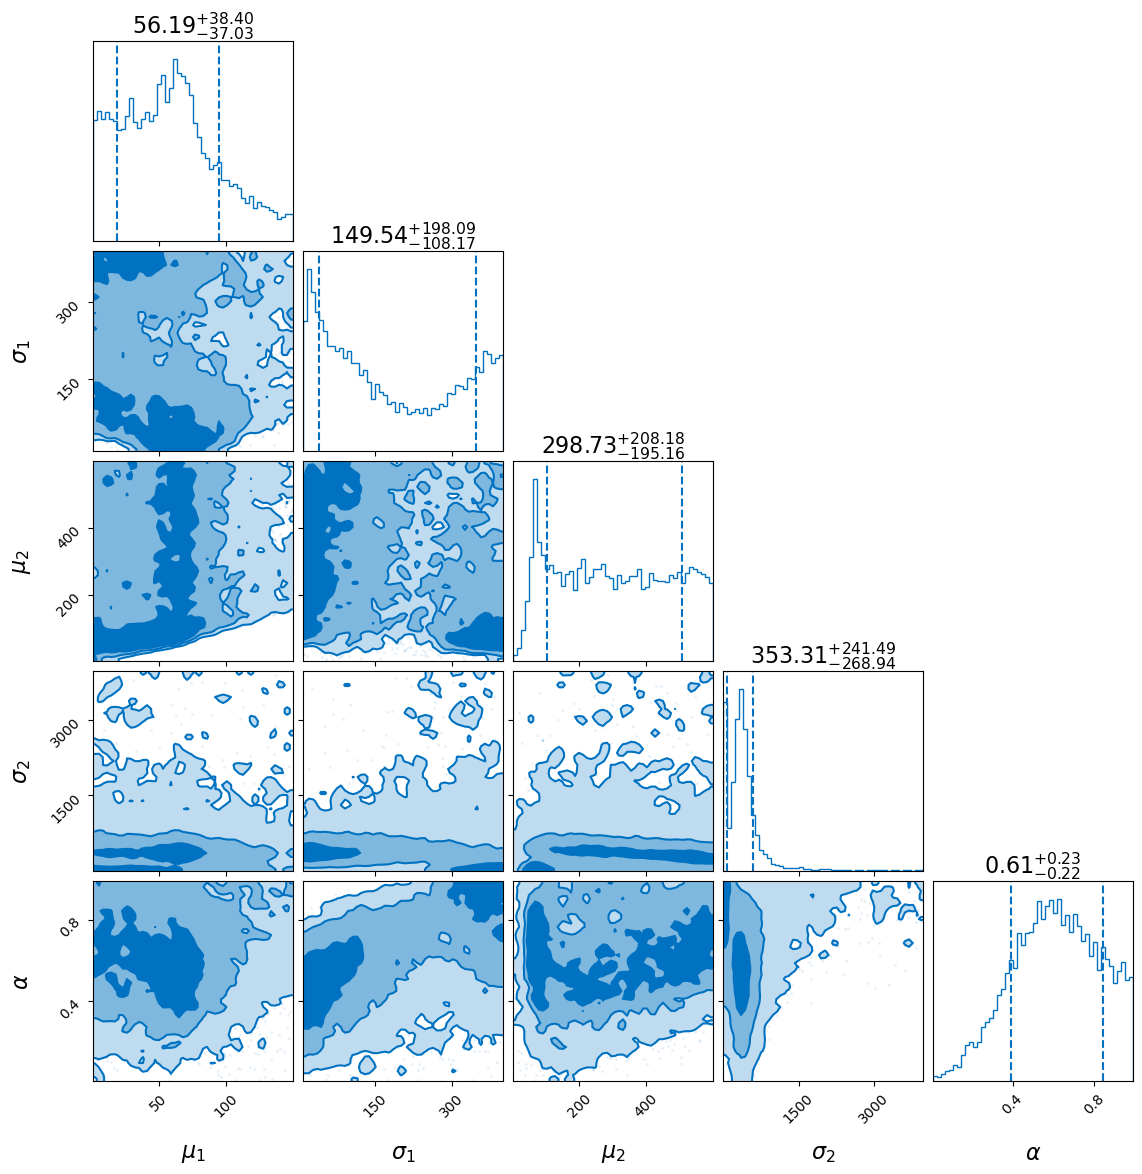

In [50]:
def hyper_prior_2G_fixed_max_min(dataset, mu1, sigma1,mu2,sigma2,alpha):
    mup=3000
    mlo=0.01
    normalisingTerm1 = 0.5 * ( erf((mu1-mlo)/(np.sqrt(2) * sigma1)) -  erf((mu1-mup)/(np.sqrt(2) * sigma1)) )
    normalisingTerm2 = 0.5 * ( erf((mu2-mlo)/(np.sqrt(2) * sigma2)) -  erf((mu2-mup)/(np.sqrt(2) * sigma2)) )
    return ((mu2 < mup ) & (mu1 > mlo) & (mu1 < mu2)  & ( dataset['mu'] >= mlo) & (dataset['mu'] <= mup)) *\
        ( (( alpha*(np.exp(- (dataset['mu'] - mu1)**2 / (2 * sigma1**2)) /(2 * np.pi * sigma1**2)**0.5)) /normalisingTerm1) +\
        (1-alpha)*( ((np.exp(- (dataset['mu'] - mu2)**2 / (2 * sigma2**2)) /(2 * np.pi * sigma2**2)**0.5) ) / normalisingTerm2) )
hp_priors_2G_fixed_max_min = dict(mu1=Uniform(1, 150, 'mu1', '$\mu_1$'),
                 sigma1=Uniform(10, 400, 'sigma1', '$\sigma_1$'),
                mu2=Uniform(1,600, 'mu2', '$\mu_2$'),
                sigma2=LogUniform(1, 4000, 'sigma2', '$\sigma_2$'),
                alpha=Uniform(0.01, 0.99, 'alpha', '$\\alpha$'))
#end two-Gausssian model with fixed lower and upper mass

hyper_prior_2G=hyper_prior_2G_fixed_max_min
hp_likelihood_2G = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_2G,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_2G =hp_priors_2G_fixed_max_min

# And run sampler
result_2G = run_sampler(
    likelihood=hp_likelihood_2G, priors=hp_priors_2G, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_2G.plot_corner()

22:51 bilby INFO    : Running for label 'u_hype_23317', output will be saved to 'hy_outdir'
22:51 bilby INFO    : Analysis priors:
22:51 bilby INFO    : mu=Uniform(minimum=1, maximum=400, name='mlo', latex_label='$\\rm{\\mu}$', unit=None, boundary=None)
22:51 bilby INFO    : sigma=LogUniform(minimum=1, maximum=1500, name='sigma', latex_label='$\\rm{\\sigma}$', unit=None, boundary=None)
22:51 bilby INFO    : nu=LogUniform(minimum=0.01, maximum=100, name='nu', latex_label='$\\rm{\\nu}$', unit=None, boundary=None)
22:51 bilby INFO    : tau=LogUniform(minimum=2.01, maximum=10, name='tau', latex_label='$\\rm{\\tau}$', unit=None, boundary=None)
22:51 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
22:51 bilby INFO    : Analysis likelihood noise evidence: 0
22:51 bilby INFO    : Single likelihood evaluation took 5.275e-04 s
22:51 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'sample': 'act-walk', 'period

1it [00:00, ?it/s]

22:55 bilby INFO    : Written checkpoint file hy_outdir/u_hype_23317_resume.pickle
22:56 bilby INFO    : Starting to close worker pool.
22:56 bilby INFO    : Finished closing worker pool.


22:56 bilby INFO    : Rejection sampling nested samples to obtain 5818 posterior samples
22:56 bilby INFO    : Sampling time: 0:04:33.974983
22:56 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
22:56 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
22:56 bilby INFO    : Summary of results:
nsamples: 5818
ln_noise_evidence:  0.000
ln_evidence: -126.241 +/-  0.063
ln_bayes_factor: -126.241 +/-  0.063



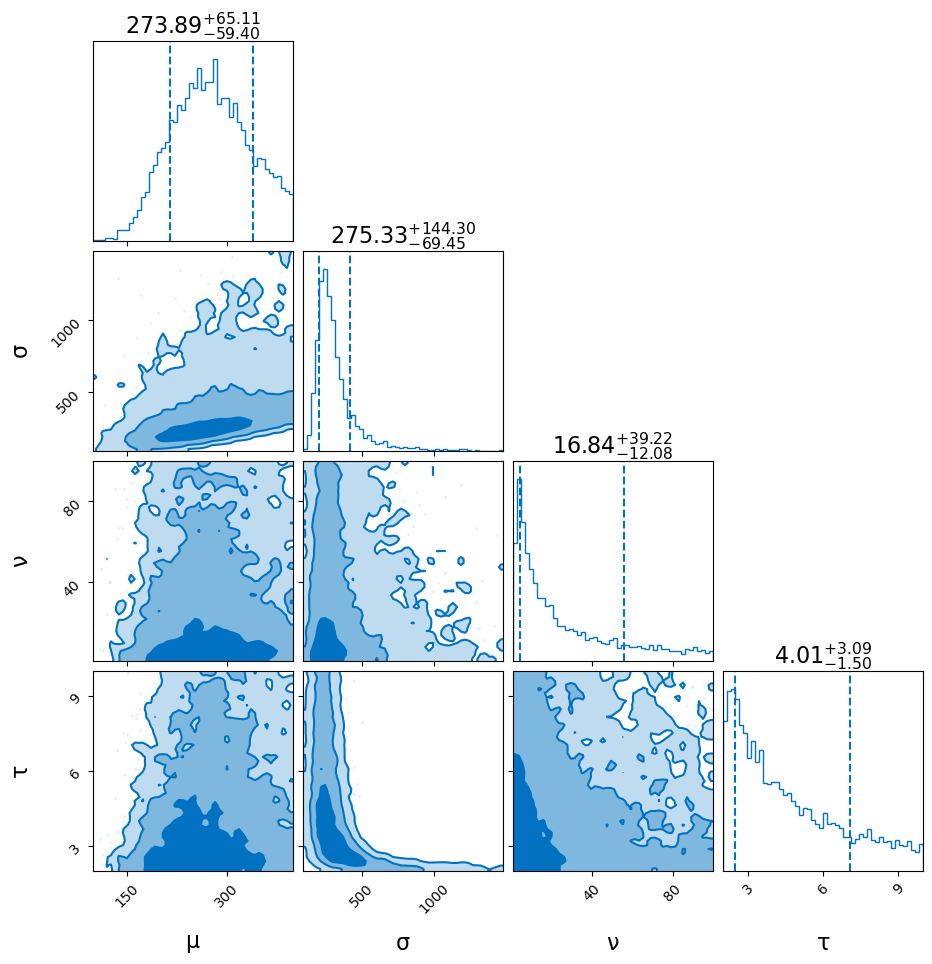

In [51]:
#begin SST
from scipy.special import beta
def hyper_prior_sst(dataset, mu,sigma,nu,tau):
        c = 2 * nu * ((1 + nu ** 2) *
                                beta(0.5, tau / 2) *
                                tau ** 0.5) ** -1
        m = ((2 * tau ** 0.5) * (nu - nu ** -1)) / (
                (tau - 1) * beta(0.5, 0.5 * tau))
        s2 = ((tau / (tau - 2)) * (
                nu ** 2 + nu ** -2 - 1) - m ** 2)
        mu_0 = mu - (sigma * m / np.sqrt(s2))
        sigma_0 = sigma / np.sqrt(s2)
        z = (dataset['mu'] - mu_0) / sigma_0
        p = np.where(dataset['mu'] < mu_0,
                     (c / sigma_0) * (1 + ((nu ** 2) * (z ** 2)) / tau) ** (
                             -(tau + 1) / 2),
                     (c / sigma_0) * (1 + (z ** 2) / ((nu ** 2) * tau)) ** (
                             -(tau + 1) / 2))
        return p

hp_priors_sst = dict(mu=Uniform(1, 400, 'mlo',r'$\rm{\mu}$'),
                sigma=LogUniform(1, 1500, 'sigma',r'$\rm{\sigma}$'),
                nu=LogUniform(0.01,100,'nu',r'$\rm{\nu}$'),
                tau=LogUniform(2.01,10,'tau',r'$\rm{\tau}$') )
#end SST

hyper_prior_sst=hyper_prior_sst
hp_likelihood_sst = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_sst,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_sst =hp_priors_sst

# And run sampler
result_sst = run_sampler(
    likelihood=hp_likelihood_sst, priors=hp_priors_sst, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_sst.plot_corner()

23:00 bilby INFO    : Running for label 'exponential_hype_12928', output will be saved to 'hy_outdir'
23:00 bilby INFO    : Analysis priors:
23:00 bilby INFO    : lam=LogUniform(minimum=0.0001, maximum=0.01, name='lam', latex_label='$\\lambda$', unit=None, boundary=None)
23:00 bilby INFO    : mlo=LogUniform(minimum=0.01, maximum=10, name='mlo', latex_label='$\\rm{v^l}$', unit=None, boundary=None)
23:00 bilby INFO    : mup=LogUniform(minimum=10, maximum=3000, name='mup', latex_label='$\\rm{v^u}$', unit=None, boundary=None)
23:00 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
23:00 bilby INFO    : Analysis likelihood noise evidence: 0
23:00 bilby INFO    : Single likelihood evaluation took 4.493e-04 s
23:00 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'rstate': None, 'queue_size': 300, 'pool':

/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /



23:01 bilby INFO    : Generating initial points from the prior
23:01 bilby INFO    : Using the bilby-implemented ensemble rwalk sampling tracking the autocorrelation function and thinning by 2 with maximum length 500000.


1it [00:00, ?it/s]

23:01 bilby INFO    : Written checkpoint file hy_outdir/exponential_hype_12928_resume.pickle
23:01 bilby INFO    : Starting to close worker pool.
23:01 bilby INFO    : Finished closing worker pool.


23:01 bilby INFO    : Rejection sampling nested samples to obtain 4283 posterior samples
23:01 bilby INFO    : Sampling time: 0:00:28.068787
23:01 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
23:01 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
23:01 bilby INFO    : Summary of results:
nsamples: 4283
ln_noise_evidence:  0.000
ln_evidence: -122.632 +/-  0.038
ln_bayes_factor: -122.632 +/-  0.038



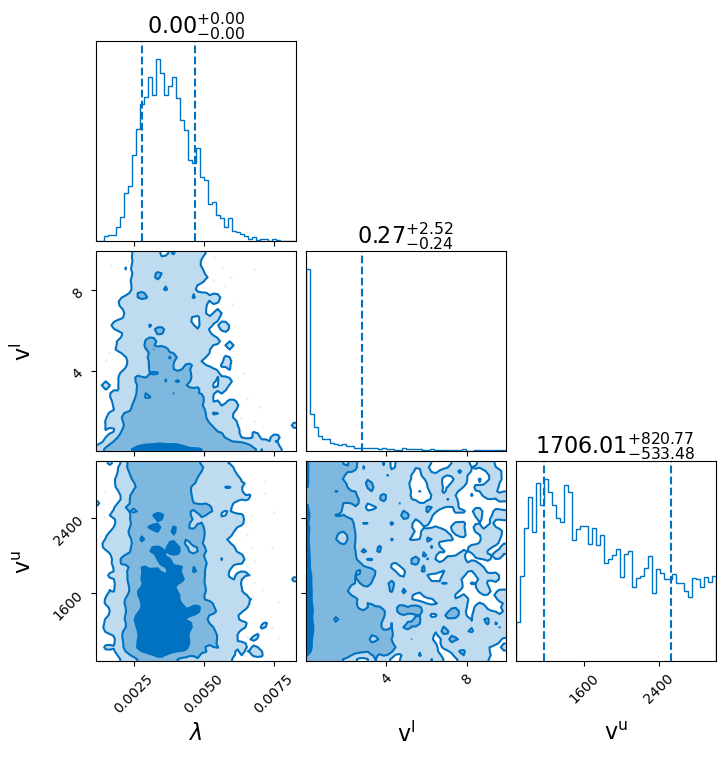

In [52]:
from scipy.stats import expon

def hyper_prior_exponential(dataset, mup, mlo, lam):
    valid_range = (dataset['mu'] >= mlo) & (dataset['mu'] <= mup)
    # Exponential PDF
    pdf_values = expon.pdf(dataset['mu'], scale=1/lam)
    # 限制范围外的概率为 0
    log_likelihood = valid_range * pdf_values
    return log_likelihood

hp_priors_exponential = dict(
    lam=LogUniform(0.0001, 0.01, 'lam', r'$\lambda$'),  # 速率参数范围
    mlo=LogUniform(0.01, 10, 'mlo', r'$\rm{v^l}$'),  # 下限范围
    mup=LogUniform(10, 3000, 'mup', r'$\rm{v^u}$')    # 上限范围
)

hyper_prior_exponential = hyper_prior_exponential

hp_likelihood_exponential = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_exponential,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_exponential = hp_priors_exponential

# 运行采样器
result_exponential = run_sampler(
    likelihood=hp_likelihood_exponential, priors=hp_priors_exponential, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='exponential_hype_{}'.format(np.random.randint(1, 88888)),
    verbose=True, clean=True, npool=npool)

# 绘制角图
result_exponential.plot_corner()

In [2]:
import bilby
latest_file_logu='/home/lz/work/pulsar_kick_velocity/hy_outdir/u_hype_62178_result.json'
result_logu = bilby.result.read_in_result(latest_file_logu)
posterior_logu=result_logu.posterior
print(posterior_logu)

            mlo          mup  log_likelihood  log_prior
0      0.123749  2964.204430     -129.161587  -8.103294
1      0.191770  1982.367447     -128.178813  -8.541332
2      0.119213   981.077070     -127.854077  -8.065951
3      0.503531  2930.265213     -127.616321  -9.506682
4      0.831257  2969.463681     -127.193710 -10.007976
...         ...          ...             ...        ...
7326  35.582131  1017.609231     -117.459703 -13.764636
7327  35.696958  1029.281283     -117.457511 -13.767858
7328  35.395163  1030.307056     -117.455865 -13.759368
7329  35.524894  1029.423806     -117.453544 -13.763027
7330  35.366640  1029.338468     -117.451317 -13.758562

[7331 rows x 4 columns]


In [6]:
def hyper_prior_logu(dataset,mlo,mup):
    return (( dataset['mu'] >= mlo) & (dataset['mu'] <= mup))/( dataset['mu'] * np.log(mup / mlo) )


In [8]:
import numpy as np

# 1. 提取后验样本
mlo = posterior_logu['mlo'].values
mup = posterior_logu['mup'].values

# 2. 计算每个样本对应的“分布平均值” (利用理论公式)
# Mean = (v_max - v_min) / ln(v_max / v_min)
v_mean_samples = (mup - mlo) / np.log(mup / mlo)

# 3. 计算 1sigma 置信区间 (16%, 50%, 84% 分位点)
# 50% 是中位数（中心值），16% 和 84% 之间涵盖了 68.3% 的概率，即 1sigma
q16, q50, q84 = np.percentile(v_mean_samples, [15.86, 50, 84.14])

# 4. 整理结果
val = q50
plus_err = q84 - q50
minus_err = q50 - q16

print(f"平均速度推导结果 (1-sigma):")
print(f"数值: {val:.1f} +{plus_err:.1f} / -{minus_err:.1f} km/s")

# 5. LaTeX 格式
print(f"LaTeX: \\langle v \\rangle = {val:.1f}^{{+{plus_err:.1f}}}_{{-{minus_err:.1f}}} \\, \\mathrm{{km/s}}")

平均速度推导结果 (1-sigma):
数值: 307.5 +83.0 / -44.4 km/s
LaTeX: \langle v \rangle = 307.5^{+83.0}_{-44.4} \, \mathrm{km/s}


In [11]:
import numpy as np
import arviz as az
from scipy.stats import gaussian_kde

# 1. 提取参数后验的 Mode (作为分布的 v_min 和 v_max)
def get_mode(samples):
    kde = gaussian_kde(samples)
    x = np.linspace(samples.min(), samples.max(), 1000)
    return x[np.argmax(kde.evaluate(x))]

v_min = get_mode(posterior_logu['mlo'].values)
v_max = get_mode(posterior_logu['mup'].values)

# 2. 计算分布本身的统计量
# Mode: Log-Uniform 的峰值就在左边界
dist_mode = v_min

# 68.3% HDI: 从左边界往右切到包含 68.3% 概率的位置
# 对于单调递减函数，HDI 的下界就是 v_min
hdi_lower = v_min
hdi_upper = v_min * (v_max / v_min)**0.683

# 90% Upper Limit: 分布的 90% 概率上限
upper_limit_90 = v_min * (v_max / v_min)**0.90

# ==========================================
# 输出结果供论文使用
# ==========================================
print(f"--- Log-Uniform 分布特征 (基于最佳估计参数) ---")
print(f"1. 峰值位置 (Mode): {dist_mode:.2f} km/s")
print(f"2. 68.3% HDI 范围: [{hdi_lower:.2f}, {hdi_upper:.2f}] km/s")
print(f"3. 90% 置信上限:  {upper_limit_90:.2f} km/s")

# --- 论文表述建议 ---
print(f"\n论文表述建议:")
print(f"The velocity distribution is characterized by a peak at {dist_mode:.1f} km/s, "
      f"with a 68.3% highest density interval spanning from {hdi_lower:.1f} to {hdi_upper:.1f} km/s. "
      f"The 90% credibility upper limit of the distribution is {upper_limit_90:.1f} km/s.")

--- Log-Uniform 分布特征 (基于最佳估计参数) ---
1. 峰值位置 (Mode): 33.58 km/s
2. 68.3% HDI 范围: [33.58, 353.92] km/s
3. 90% 置信上限:  747.96 km/s

论文表述建议:
The velocity distribution is characterized by a peak at 33.6 km/s, with a 68.3% highest density interval spanning from 33.6 to 353.9 km/s. The 90% credibility upper limit of the distribution is 748.0 km/s.


In [7]:
import numpy as np
import arviz as az
from scipy.stats import gaussian_kde

# 1. 提取后验
mlo_samples = posterior_logu['mlo'].values
mup_samples = posterior_logu['mup'].values

# ==========================================
# 1. 计算衍生物理量 (Derived Quantities)
# ==========================================
v_mean_samples = (mup_samples - mlo_samples) / np.log(mup_samples / mlo_samples)
v_mode_samples = mlo_samples 

# ==========================================
# 2. 修正后的统计函数
# ==========================================
def get_full_stats(samples, name):
    # 计算均值 (Mean)
    mean_val = np.mean(samples)
    
    # --- 修正点：手动计算 Mode (KDE 峰值) ---
    try:
        kde = gaussian_kde(samples)
        # 在样本范围内生成 1000 个点寻找最大值
        x_grid = np.linspace(np.min(samples), np.max(samples), 1000)
        kde_vals = kde.evaluate(x_grid)
        mode_val = x_grid[np.argmax(kde_vals)]
    except:
        # 如果样本太少导致 KDE 失败，回退到简单的直方图众数
        mode_val = np.median(samples) 
    
    # 计算 HDI (最高密度区间) - arviz 这个函数是存在的
    hdi_68 = az.hdi(samples, hdi_prob=0.683)
    hdi_90 = az.hdi(samples, hdi_prob=0.90)
    
    print(f"统计项: [{name}]")
    print(f"  Mean (均值):   {mean_val:.2f}")
    print(f"  Mode (众数):   {mode_val:.2f}")
    print(f"  68.3% HDI:    [{hdi_68[0]:.2f}, {hdi_68[1]:.2f}]")
    print(f"  90.0% HDI:    [{hdi_90[0]:.2f}, {hdi_90[1]:.2f}]")
    print("-" * 40)
    
    return mean_val, hdi_68, hdi_90

# ==========================================
# 3. 执行并输出
# ==========================================
print("\n" + "="*50)
print(" >>> Log-Uniform 模型物理参数统计 <<<")
print("="*50)

# 统计参数本身
get_full_stats(mlo_samples, "Parameter m_lo")
get_full_stats(mup_samples, "Parameter m_up")

# 统计物理特征速度
mean_v, hdi68_v, _ = get_full_stats(v_mean_samples, "Characteristic Mean Velocity <v>")
peak_v, hdi68_p, _ = get_full_stats(v_mode_samples, "Peak Velocity v_peak")

# 打印 LaTeX
upper_err = hdi68_v[1] - mean_v
lower_err = mean_v - hdi68_v[0]
print(f"LaTeX Mean: \\langle v \\rangle = {mean_v:.1f}^{{+{upper_err:.1f}}}_{{-{lower_err:.1f}}} \\, \\mathrm{{km/s}}")


 >>> Log-Uniform 模型物理参数统计 <<<
统计项: [Parameter m_lo]
  Mean (均值):   26.69
  Mode (众数):   33.58
  68.3% HDI:    [20.90, 38.39]
  90.0% HDI:    [11.69, 40.26]
----------------------------------------
统计项: [Parameter m_up]
  Mean (均值):   1316.02
  Mode (众数):   1055.93
  68.3% HDI:    [899.74, 1371.80]
  90.0% HDI:    [878.20, 1840.64]
----------------------------------------
统计项: [Characteristic Mean Velocity <v>]
  Mean (均值):   324.53
  Mode (众数):   287.59
  68.3% HDI:    [246.78, 360.18]
  90.0% HDI:    [221.45, 446.35]
----------------------------------------
统计项: [Peak Velocity v_peak]
  Mean (均值):   26.69
  Mode (众数):   33.58
  68.3% HDI:    [20.90, 38.39]
  90.0% HDI:    [11.69, 40.26]
----------------------------------------
LaTeX Mean: \langle v \rangle = 324.5^{+35.6}_{-77.8} \, \mathrm{km/s}


ValueError: '' is not a valid color value.

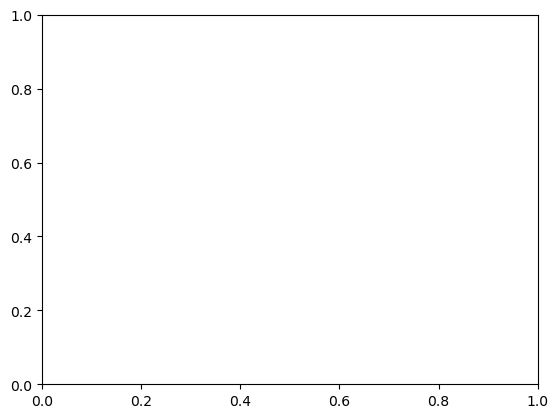

In [7]:
x=np.linspace(min(samples_new),max(samples_new),1000)
mlo_logu = posterior_logu['mlo']  # 从 posterior 中提取后验值 
mup_logu= posterior_logu['mup']
mlo_logu_median = np.median(mlo_logu)
mup_logu_median = np.median(mup_logu)
dataset_x = {'mu': x}
prior_distribution_logu=hyper_prior_logu(dataset_x,mlo_logu_median,mup_logu_median)
# 计算所有样本对应的先验分布
prior_lines = []
for i in range(len(mlo_logu)):
    prior_distribution = hyper_prior_logu(dataset_x,mlo_logu[i],mup_logu[i])
    prior_lines.append(prior_distribution)

# 将所有样本的先验分布堆叠起来（按列堆叠，构成一个矩阵）
prior_lines = np.array(prior_lines)
average_prior_distribution = np.mean(prior_lines, axis=0)
# 计算 90% 置信区间（所有先验分布的 5% 和 95% 分位数）
lower_90 = np.percentile(prior_lines, 5, axis=0)  # 5% 分位数
upper_90 = np.percentile(prior_lines, 95, axis=0)  # 95% 分位数
plt.fill_between(x, lower_90, upper_90, color='', alpha=0.6, label='90% CI')
plt.plot(x, prior_distribution_logu)
plt.hist(samples_new,density=True,bins=50,color='white',edgecolor='black',alpha=1,label='Samples')
plt.xlim(0,2000)
# 显示图形
plt.show()

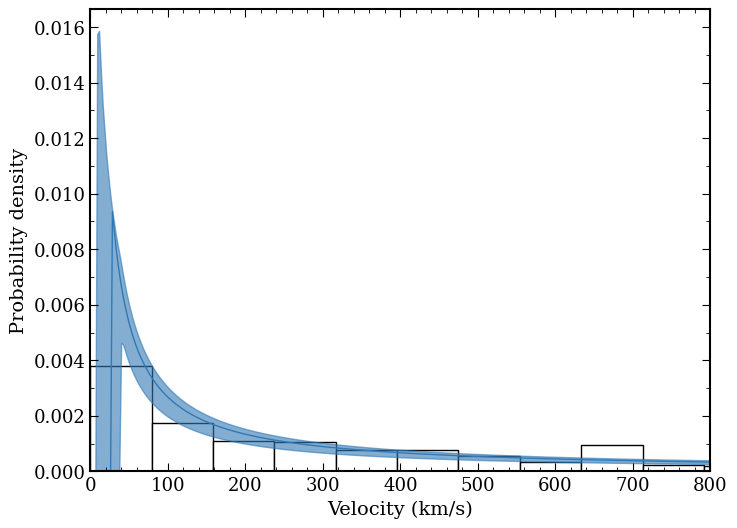

In [10]:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator,FuncFormatter
from scipy.stats import maxwell
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["STIX Two Text", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "axes.linewidth": 1.5,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
})

fig,ax=plt.subplots(figsize=(8,6))

plt.hist(samples_radial_18,density=True,bins=30,color='white',edgecolor='black',alpha=1,linestyle='-',label='Samples of Radial Velocity')
plt.fill_between(x, lower_90, upper_90, color='#3179B5', alpha=0.6, label='90% CI')
plt.plot(x, prior_distribution_logu,color='#3179B5',linewidth=1,label='Log-Uniform Model')
#plt.hist(V_2D_trans,density=True,bins=5,histtype='step',color='white',edgecolor='black',alpha=1,linestyle='-.',label='25 Samples of 2D Velocity')
#plt.fill_between(x, lower_90, upper_90, color='#3179B5', alpha=0.3, label='90% CI')  #danube color #3179B5
#plt.plot(x, prior_distribution_logu)
plt.xlim(0,800)
# 显示图形
plt.tick_params(top='on', right='on', which='both')
ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(0.001))
ax.tick_params(axis='both',which='both',direction='in')
# 画Hobbs2005图
x_range = np.linspace(0, 1500, 500)  # Range of x from 0 to 1500
pdf_values = maxwell.pdf(x_range, scale=265)
#plt.plot(x_range, pdf_values, color='black',linewidth=1,label=r"Hobbs et al.(2005)")
#plt.legend(loc='upper right')
plt.xlabel('Velocity (km/s)',fontsize=14)
plt.ylabel('Probability density',fontsize=14)
plt.savefig('pdf_1D_Radial_Velocity.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()